In [1]:
! pip install spacy
! python -m spacy download pt_core_news_lg

Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 187, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/usr/lib/python3.10/runpy.py", line 146, in _get_module_details
    return _get_module_details(pkg_main_name, error)
  File "/usr/lib/python3.10/runpy.py", line 110, in _get_module_details
    __import__(pkg_name)
  File "/usr/local/lib/python3.10/dist-packages/spacy/__init__.py", line 6, in <module>
    from .errors import setup_default_warnings
  File "/usr/local/lib/python3.10/dist-packages/spacy/errors.py", line 3, in <module>
    from .compat import Literal
  File "/usr/local/lib/python3.10/dist-packages/spacy/compat.py", line 4, in <module>
    from thinc.util import copy_array
  File "/usr/local/lib/python3.10/dist-packages/thinc/__init__.py", line 5, in <module>
    from .config import registry
  File "/usr/local/lib/python3.10/dist-packages/thinc/config.py", line 5, in <module>
    from .types im

In [2]:
!pip install datasets

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 5

In [3]:
import random
from spacy.util import minibatch, compounding
from spacy.training import Example
from spacy.training import offsets_to_biluo_tags

In [4]:
import numpy as np
import pandas as pd
import string
import random
import re
import spacy
import gensim
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords

from spacy.lang.pt.stop_words import STOP_WORDS
from spacy import displacy
from spacy.util import minibatch, compounding
from spacy.training import Example
from spacy.training import offsets_to_biluo_tags
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.cluster import DBSCAN
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering


In [5]:
import spacy

nlp = spacy.load("pt_core_news_lg")

In [6]:
df = pd.read_csv('/content/dadosTextosCientificos.tsv',
                   sep='\t',
                   engine='python',
                   encoding='latin-1')

In [7]:
df

,Título_Público,Descricao_pública
0,Açúcar de frutas e aplicação em bolos como sub...,O uso de inovações tecnológicas auxilia as ind...
1,Desenvolver uma linha de farofas com castanhas...,O uso de inovações tecnológicas auxilia as ind...
2,Desenvolvimento de cobertura líquida para sorvete,O Brasil é considerado um país com a maior bio...
3,Desenvolvimento de conserva de tomate cereja,O Brasil é considerado o país com maior biodiv...
4,Desenvolvimento de massa alimentícia enriqueci...,Nos últimos anos a comunidade científica tem d...
...,...,...
2720,Desenvolvimento de ativos biotecnológicos para...,O avanço das tecnologias para estudos genômico...
2721,SIMA MV POWER,Projeto de PD&I para desenvolvimento de um sis...
2722,Talhonameno Ótimo Klabin,"A Klabin S/A é uma empresa brasileira, de cará..."
2723,Tecnologia de Quantificação de Estoque de Carb...,Com a execução do presente projeto espera-se d...


In [8]:
df.shape

(2725, 2)

In [9]:
sample_review=df.Descricao_pública[0]
sample_review

'O uso de inovações tecnológicas auxilia as indústrias a desenvolverem modelos sustentáveis de produção, produtos e serviços de forma sustentável a partir de recursos de base biológica com papel importante no desenvolvimento econômico do Brasil, dessa maneira, contribui para os Objetivos de Desenvolvimento Sustentável (ODS) estabelecidos pela Organização das Nações Unidas (ONU) especialmente no âmbito do Objetivo 12 (Assegurar padrões de produção e de consumo sustentáveis). Diante desse cenário, a presenta proposta buscará desenvolver e produzir frutose em pó  que substitua a sacarose para atender o mercado de indústrias de alimentos.'

In [10]:
titulo=df.Título_Público[35]
titulo

'AGORA DIGITAL'

In [11]:
import pandas as pd

# Exibir linhas com NaN na coluna específica
print(df[df["Descricao_pública"].isna()])

# Contar valores NaN por coluna
print(df.isna().sum())

                                        Título_Público Descricao_pública
539                                                NaN               NaN
540                                                NaN               NaN
541                                                NaN               NaN
870  Mancais Magnéticos para Aplicação na Indústria...               NaN
Título_Público       3
Descricao_pública    4
dtype: int64


In [12]:
df = df.dropna(subset=["Descricao_pública"])

In [13]:
# Adiciona o NER ao pipeline do spaCy (caso ainda não esteja)
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
else:
    ner = nlp.get_pipe("ner")

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Criar o vetor TF-IDF
vectorizer = TfidfVectorizer(max_features=100)  # Limitar para 100 palavras mais importantes
tfidf_matrix = vectorizer.fit_transform(df["Descricao_pública"])

# Palavras-chave extraídas
print(vectorizer.get_feature_names_out())

# Exemplo: Matriz TF-IDF
print(tfidf_matrix.toarray())

['além' 'ambiente' 'análise' 'ao' 'aos' 'aplicação' 'aplicações'
 'artificial' 'as' 'assim' 'através' 'base' 'capaz' 'com' 'como'
 'componentes' 'controle' 'da' 'dados' 'das' 'de' 'desempenho'
 'desenvolver' 'desenvolvimento' 'deste' 'diferentes' 'dispositivos' 'do'
 'dos' 'eficiência' 'em' 'empresa' 'energia' 'entre' 'equipamentos' 'este'
 'forma' 'gestão' 'indústria' 'informações' 'inteligente' 'inteligência'
 'maior' 'mais' 'materiais' 'meio' 'mercado' 'modelos' 'monitoramento'
 'na' 'nas' 'neste' 'no' 'nos' 'não' 'objetivo' 'os' 'ou' 'para' 'partir'
 'pela' 'pesquisa' 'plataforma' 'por' 'processamento' 'processo'
 'processos' 'produto' 'produtos' 'produção' 'projeto' 'propriedades'
 'protótipo' 'qualidade' 'que' 'realizar' 'se' 'ser' 'será' 'serão'
 'sistema' 'sistemas' 'software' 'solução' 'soluções' 'sua' 'são' 'também'
 'tecnologia' 'tecnologias' 'tem' 'testes' 'tratamento' 'técnicas' 'um'
 'uma' 'uso' 'utilizando' 'visa' 'visando']
[[0.         0.         0.         ... 0.     

In [15]:
import pandas as pd

# Lista de palavras que você quer verificar
words_to_find = ['artificial', 'inteligente', 'inteligência', 'tecnologia', 'tecnologias', 'processamento', 'software', 'solução', 'soluções',
                 'desenvolver', 'desenvolvimento', 'produção', 'processos', 'controle', 'eficiência', 'monitoramento', 'testes', 'qualidade',
                 'indústria', 'empresa', 'mercado', 'equipamentos', 'energia', 'materiais', 'dados', 'informações', 'sistemas', 'produtos', 'plataforma']

# Obter as palavras (features) do modelo
features = vectorizer.get_feature_names_out()

# Converter a matriz TF-IDF em um DataFrame para manipulação fácil
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=features)

# Loop para verificar a primeira ocorrência de cada palavra nos documentos
for word in words_to_find:
    if word in df_tfidf.columns:
        # Encontrar o índice do primeiro documento em que a palavra aparece (onde o valor é > 0)
        first_occurrence = df_tfidf[word].gt(0).idxmax()  # `idxmax` retorna o primeiro índice de valor True
        print(f"Palavra '{word}' aparece pela primeira vez no documento {first_occurrence}")
    else:
        print(f"Palavra '{word}' não aparece em nenhum documento.")

Palavra 'artificial' aparece pela primeira vez no documento 22
Palavra 'inteligente' aparece pela primeira vez no documento 30
Palavra 'inteligência' aparece pela primeira vez no documento 22
Palavra 'tecnologia' aparece pela primeira vez no documento 7
Palavra 'tecnologias' aparece pela primeira vez no documento 41
Palavra 'processamento' aparece pela primeira vez no documento 29
Palavra 'software' aparece pela primeira vez no documento 27
Palavra 'solução' aparece pela primeira vez no documento 17
Palavra 'soluções' aparece pela primeira vez no documento 73
Palavra 'desenvolver' aparece pela primeira vez no documento 0
Palavra 'desenvolvimento' aparece pela primeira vez no documento 0
Palavra 'produção' aparece pela primeira vez no documento 0
Palavra 'processos' aparece pela primeira vez no documento 1
Palavra 'controle' aparece pela primeira vez no documento 11
Palavra 'eficiência' aparece pela primeira vez no documento 20
Palavra 'monitoramento' aparece pela primeira vez no docume

In [16]:
TRAINING_DATA = [
    ("a presenta proposta buscará desenvolver e produzir frutose em pó  que substitua a sacarose para atender o mercado de indústrias de alimentos", {"entities": [(28, 39, "Processos")]}),
    ("produtos e serviços de forma sustentável a partir de recursos de base biológica com papel importante no desenvolvimento econômico do Brasil", {"entities": [(0, 8, "Indústria")]}),
    ("Assegurar padrões de produção e de consumo sustentáveis", {"entities": [(21, 29, "Processos")]}),
    ("a presenta proposta buscará desenvolver e produzir frutose em pó  que substitua a sacarose para atender o mercado de indústrias de alimentos", {"entities": [(106, 113, "Indústria")]}),
    ("contribui para os Objetivos de Desenvolvimento Sustentável", {"entities": [(31, 46, "Processos")]}),
    ("A empresa está em busca de apoio na inovação e melhoria dos processos para desenvolver uma linha de produção sustentável com o uso de castanhas brasileiras", {"entities": [(2, 9, "Indústria")]}),
    ("A empresa está em busca de apoio na inovação e melhoria dos processos para desenvolver uma linha de produção sustentável com o uso de castanhas brasileiras", {"entities": [(60, 69, "Processos")]}),
    ("Os pesquisadores na área da tecnologia de alimentos destacam a importância de pesquisas com o objetivo de inserir no mercado", {"entities": [(28, 38, "Tecnologia")]}),
    ("Visando atender a busca por alimentos de qualidade e", {"entities": [(41, 50, "Processos")]}),
    ("A capacidade de produção de energia influencia muito o desempenho do atleta", {"entities": [(28, 35, "Indústria")]}),
    ("o que pode contribuir para a redução do êxodo rural e desenvolvimento da indústria com agregação no valor do produto final", {"entities": [(73, 82, "Indústria")]}),
    ("maximizando o potencial como agentes de controle", {"entities": [(40, 48, "Processos")]}),
    ("O projeto em questão é o desenvolvimento de uma solução IoT capaz monitorar e transmitir informações sobre a vida de sistemas de transmissão", {"entities": [(48, 55, "Tecnologia")]}),
    ("O projeto em questão é o desenvolvimento de uma solução IoT capaz monitorar e transmitir informações sobre a vida de sistemas de transmissão", {"entities": [(89, 100, "Indústria")]}),
    ("O projeto em questão é o desenvolvimento de uma solução IoT capaz monitorar e transmitir informações sobre a vida de sistemas de transmissão", {"entities": [(117, 125, "Indústria")]}),
    ("será composto por um módulo de conectividade para permitir o registro de dados na nuvem", {"entities": [(73, 78, "Indústria")]}),
    ("será necessário realizar testes em sistemas de transmissão", {"entities": [(25, 31, "Processos")]}),
    ("O resultado esperado é um sensor de vibração IoT preciso e confiável que possa ser utilizado em diferentes setores industriais para monitorar a vibração em tempo real e ajudar a prevenir falhas de equipamentos", {"entities": [(197, 209, "Indústria")]}),
    ("maior eficiência de transmissão", {"entities": [(6, 16, "Processos")]}),
    ("baseada em Inteligência Artificial", {"entities": [(11, 23, "Tecnologia")]}),
    ("baseada em Inteligência Artificial", {"entities": [(24, 34, "Tecnologia")]}),
    ("O produto a ser desenvolvido nesta proposta será um dispositivo sensor para monitoramento prévio de falhas em máquinas rotativas", {"entities": [(76, 89, "Processos")]}),
    ("Projeto e desenvolvimento de um arcabouço de ferramentas de software em nível de prova de conceito para a avaliação de modelos de serviços e aplicações para redes de 5G com o uso da computação na borda", {"entities": [(60, 68, "Tecnologia")]}),
    ("Plataforma de software para Edge Computing baseada em 5G", {"entities": [(0, 10, "Indústria")]}),
    ("Desenvolvimento de solução tecnológica para prover a automação e inovação no processo de registro, processamento e análise de informações contábeis", {"entities": [(99, 102, "Tecnologia")]}),
    ("Prototipação  de COMPONENTES DE INTERCEPTAÇÃO INTELIGENTE (CII) que utilizem métricas de microsserviços para, através de inteligência artificial, melhorar o desempenho do microsserviço", {"entities": [(46, 57, "Tecnologia")]}),
    ("O projeto se refere à pesquisa e desenvolvimento de uma solução de software baseada em tecnologias de big data combinadas para realizar o processamento de grandes quantidades de dados de telemetria", {"entities": [(87, 98, "Tecnologia")]}),
    ("soluções para garantir a integridade das imagens usadas e para verificar o uso adequado dos recursos requisitados", {"entities": [(0, 8, "Tecnologia")]}),
    ("implementar e avaliar uma abordagem baseada em Agentes Inteligentes para compra de órteses, próteses e outros materiais hospitalares especiais", {"entities": [(110, 119, "Indústria")]}),
]

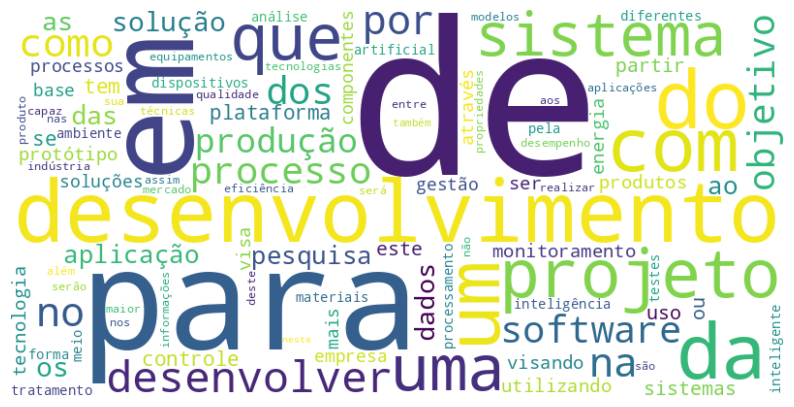

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Obter os nomes das palavras e suas respectivas pontuações TF-IDF
words = vectorizer.get_feature_names_out()
scores = tfidf_matrix.sum(axis=0).A1  # Soma as pontuações TF-IDF de todas as palavras

# Criar um dicionário de palavras e suas pontuações
word_scores = dict(zip(words, scores))

# Gerar a nuvem de palavras
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_scores)

# Mostrar a nuvem de palavras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

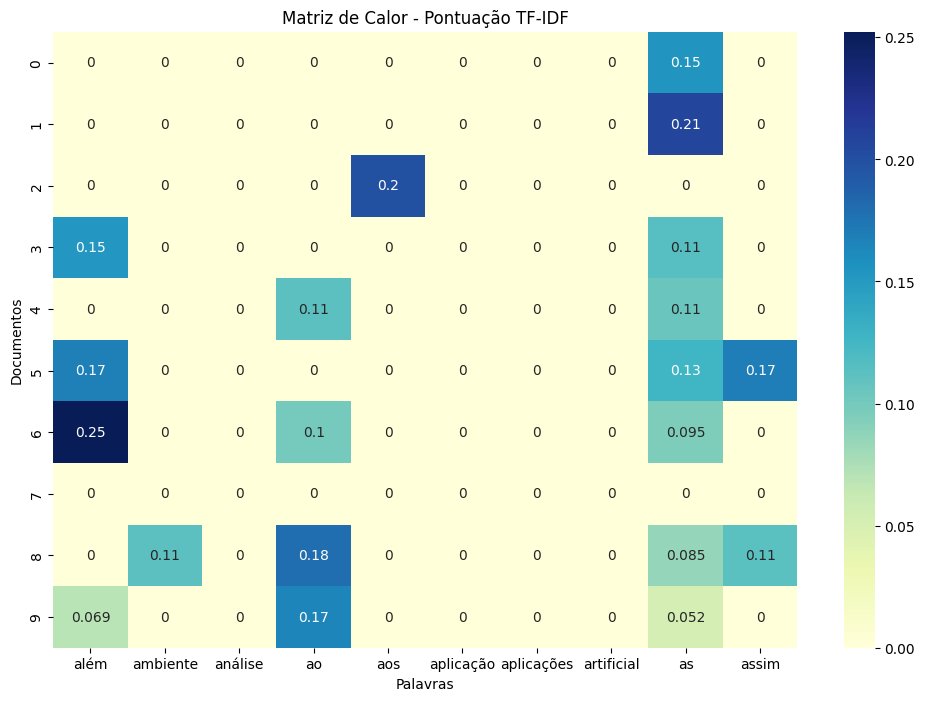

In [18]:
import seaborn as sns
import pandas as pd

# Converter a matriz TF-IDF para um DataFrame
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=words)

# Selecionar um subconjunto de palavras e documentos (se necessário)
df_tfidf_subset = df_tfidf.iloc[:10, :10]  # Exemplo: 10 primeiros documentos e 10 primeiras palavras

# Criar a matriz de calor
plt.figure(figsize=(12, 8))
sns.heatmap(df_tfidf_subset, annot=True, cmap="YlGnBu", cbar=True, xticklabels=True, yticklabels=True)
plt.title("Matriz de Calor - Pontuação TF-IDF")
plt.xlabel("Palavras")
plt.ylabel("Documentos")
plt.show()

In [19]:
# Função para obter as palavras mais relevantes de um documento específico com o seu conteúdo
def palavras_relevantes_por_documento(documento_idx, num_palavras=15):
    documento_scores = pd.Series(scores[documento_idx], index=words)
    documento_scores_sorted = documento_scores.sort_values(ascending=False).head(num_palavras)

    # Obter o texto do documento
    documento_texto = df["Descricao_pública"].iloc[documento_idx]

    print(f"Documento {documento_idx}:\n{documento_texto}\n")
    print(f"Palavras mais relevantes (TF-IDF):")
    print(documento_scores_sorted)

# Exibir para o primeiro documento
palavras_relevantes_por_documento(75)

Documento 75:
O objetivo do projeto é investigar, conceber, implementar e avaliar uma abordagem baseada em Agentes Inteligentes para compra de órteses, próteses e outros materiais hospitalares especiais.

Palavras mais relevantes (TF-IDF):
além             33.116699
por              33.116699
qualidade        33.116699
protótipo        33.116699
propriedades     33.116699
projeto          33.116699
produção         33.116699
produtos         33.116699
produto          33.116699
processos        33.116699
processo         33.116699
processamento    33.116699
plataforma       33.116699
ambiente         33.116699
pesquisa         33.116699
dtype: float64


In [20]:
parsed_review = nlp(sample_review)
parsed_review

O uso de inovações tecnológicas auxilia as indústrias a desenvolverem modelos sustentáveis de produção, produtos e serviços de forma sustentável a partir de recursos de base biológica com papel importante no desenvolvimento econômico do Brasil, dessa maneira, contribui para os Objetivos de Desenvolvimento Sustentável (ODS) estabelecidos pela Organização das Nações Unidas (ONU) especialmente no âmbito do Objetivo 12 (Assegurar padrões de produção e de consumo sustentáveis). Diante desse cenário, a presenta proposta buscará desenvolver e produzir frutose em pó  que substitua a sacarose para atender o mercado de indústrias de alimentos.

In [21]:
for ent in parsed_review.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Brasil 237 243 LOC
Objetivos de Desenvolvimento Sustentável 278 318 ORG
ODS 320 323 ORG
Organização das Nações Unidas 344 373 ORG
ONU 375 378 ORG
Objetivo 407 415 ORG


In [22]:
spacy.displacy.render(parsed_review, style='ent', jupyter=True)

In [23]:
texto1 = df.iloc[0, 1]
texto2 = df.iloc[1, 1]
texto3 = df.iloc[2, 1]
texto4 = df.iloc[3, 1]
texto5 = df.iloc[4, 1]

texts = [
    texto1,
    texto2,
    texto3,
    texto4,
    texto5
]

tokenized_text = pd.DataFrame()

for i, token in enumerate(parsed_review):
    tokenized_text.loc[i, 'text'] = token.text
    tokenized_text.loc[i, 'lemma'] = token.lemma_,
    tokenized_text.loc[i, 'pos'] = token.pos_
    tokenized_text.loc[i, 'tag'] = token.tag_
    tokenized_text.loc[i, 'dep'] = token.dep_
    tokenized_text.loc[i, 'shape'] = token.shape_
    tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
    tokenized_text.loc[i, 'is_stop'] = token.is_stop
    tokenized_text.loc[i, 'is_punctuation'] = token.is_punct

tokenized_text[:20]

,text,lemma,pos,tag,dep,shape,is_alpha,is_stop,is_punctuation
0,O,"(o,)",DET,DET,det,X,True,True,False
1,uso,"(uso,)",NOUN,NOUN,nsubj,xxx,True,False,False
2,de,"(de,)",ADP,ADP,case,xx,True,True,False
3,inovações,"(inovação,)",NOUN,NOUN,nmod,xxxx,True,False,False
4,tecnológicas,"(tecnológico,)",ADJ,ADJ,amod,xxxx,True,False,False
5,auxilia,"(auxiliar,)",VERB,VERB,ROOT,xxxx,True,False,False
6,as,"(o,)",DET,DET,det,xx,True,True,False
7,indústrias,"(indústria,)",NOUN,NOUN,nsubj,xxxx,True,False,False
8,a,"(a,)",SCONJ,SCONJ,mark,x,True,True,False
9,desenvolverem,"(desenvolver,)",VERB,VERB,acl,xxxx,True,False,False


In [24]:
noun_chunks_df = pd.DataFrame()

for i, chunk in enumerate(parsed_review.noun_chunks):
    noun_chunks_df.loc[i, 'text'] = chunk.text
    noun_chunks_df.loc[i, 'root'] = chunk.root,
    noun_chunks_df.loc[i, 'root.text'] = chunk.root.text,
    noun_chunks_df.loc[i, 'root.dep_'] = chunk.root.dep_
    noun_chunks_df.loc[i, 'root.head.text'] = chunk.root.head.text

noun_chunks_df[:20]

,text,root,root.text,root.dep_,root.head.text
0,O uso,"(uso,)","(uso,)",nsubj,auxilia
1,inovações tecnológicas,"(inovações,)","(inovações,)",nmod,uso
2,as indústrias,"(indústrias,)","(indústrias,)",nsubj,contribui
3,modelos sustentáveis,"(modelos,)","(modelos,)",obj,desenvolverem
4,produção,"(produção,)","(produção,)",nmod,modelos
5,", produtos","(produtos,)","(produtos,)",conj,produção
6,serviços,"(serviços,)","(serviços,)",conj,produção
7,forma sustentável,"(forma,)","(forma,)",nmod,serviços
8,partir de recursos,"(recursos,)","(recursos,)",nmod,modelos
9,base biológica,"(base,)","(base,)",nmod,recursos


In [25]:
# Extração e contagem de dependências em uma frase
def extract_dependency_counts(parsed_review):
    dep_counts = Counter([token.dep_ for token in parsed_review])
    return dep_counts

# Extração e contagem de NERs em uma frase
def extract_ner_counts(parsed_review):
    ner_counts = Counter([ent.label_ for ent in parsed_review.ents])
    return ner_counts

# Analise dos textos, extração e contagem de NERs e dependências
dep_features = []
ner_features = []
for text in texts:
    doc = nlp(text)
    dep_counts = extract_dependency_counts(doc)
    ner_counts = extract_ner_counts(doc)
    dep_features.append(dep_counts)
    ner_features.append(ner_counts)

# Criação de um conjunto único de relações de dependência e labels NER para vetorização
all_dependencies = set(dep for dep_count in dep_features for dep in dep_count.keys())
all_ner_labels = set(ner for ner_count in ner_features for ner in ner_count.keys())

# converte a contagem de dependências em uma matriz
dep_features_matrix = []
for dep_count in dep_features:
    # Create a vector based on the presence/frequency of each dependency relation
    vector = [dep_count.get(dep, 0) for dep in all_dependencies]
    dep_features_matrix.append(vector)

# Converte a contagem de NERs em uma matriz
ner_features_matrix = []
for ner_count in ner_features:
    # Create a vector based on the presence/frequency of each NER type
    vector = [ner_count.get(ner, 0) for ner in all_ner_labels]
    ner_features_matrix.append(vector)

# Converte ambas as martizes em array do numpy
dep_features_matrix = np.array(dep_features_matrix)
ner_features_matrix = np.array(ner_features_matrix)

# Padronização dos atributos de dependências e NER
scaler = StandardScaler()
dep_features_scaled = scaler.fit_transform(dep_features_matrix)
ner_features_scaled = scaler.fit_transform(ner_features_matrix)

# Alvo de 3 clusters
num_clusters = 3  # Set the number of clusters

# Combina os atributos advindos das dependências e das NERs
combined_features = np.hstack((dep_features_scaled, ner_features_scaled))

In [26]:
# Aplica K-means
num_clusters = 3  # Set the number of clusters
kmeans_combined = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_combined.fit(combined_features)

# Cria labels para os clusters
clusters_combined = kmeans_combined.labels_

In [27]:
# Resultados
for i, text in enumerate(texts):
    print(f"Text {i+1}: {text}")
    print(f"Assigned Cluster: {clusters_combined[i]}\n")

Text 1: O uso de inovações tecnológicas auxilia as indústrias a desenvolverem modelos sustentáveis de produção, produtos e serviços de forma sustentável a partir de recursos de base biológica com papel importante no desenvolvimento econômico do Brasil, dessa maneira, contribui para os Objetivos de Desenvolvimento Sustentável (ODS) estabelecidos pela Organização das Nações Unidas (ONU) especialmente no âmbito do Objetivo 12 (Assegurar padrões de produção e de consumo sustentáveis). Diante desse cenário, a presenta proposta buscará desenvolver e produzir frutose em pó  que substitua a sacarose para atender o mercado de indústrias de alimentos.
Assigned Cluster: 2

Text 2: O uso de inovações tecnológicas auxilia as indústrias a desenvolverem modelos sustentáveis de produção, destaca-se a necessidade de pesquisas com o objetivo de desenvolver produto inovador pronto para consumo, agregação de valor e diferenciação de sabores, em especial produtos oriundos das florestas brasileiras que cont

In [28]:
from spacy.training import offsets_to_biluo_tags

In [29]:
# Add new labels to the NER
for _, annotations in TRAINING_DATA:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

In [30]:
# Disable other pipes during training (we only want to train NER)
with nlp.disable_pipes(*[pipe for pipe in nlp.pipe_names if pipe != "ner"]):
    # Initialize the optimizer
    optimizer = nlp.create_optimizer()

    # Training the model for more epochs
    for iteration in range(100):  # Train for more iterations
        random.shuffle(TRAINING_DATA)
        losses = {}

        # Create batches of training data using minibatch
        batches = minibatch(TRAINING_DATA, size=compounding(4.0, 32.0, 1.001))

        for batch in batches:
            examples = []
            for text, annotations in batch:
                doc = nlp.make_doc(text)
                try:
                    example = Example.from_dict(doc, annotations)
                except ValueError:
                    print(f"Skipping misaligned entities in: '{text}'")
                    continue
                examples.append(example)

            # Update the model
            nlp.update(examples, sgd=optimizer, drop=0.35, losses=losses)

        print(f"Iteration {iteration} Losses: {losses}")

        # Early stopping condition (stop if losses are minimal or don't improve)
        if losses.get("ner", 0) < 0.01:
            print(f"Early stopping at iteration {iteration}")
            break

# Save the trained model
nlp.to_disk("custom_ner_model")

Iteration 0 Losses: {'ner': 68.73089800944152}
Iteration 1 Losses: {'ner': 59.56809996064112}
Iteration 2 Losses: {'ner': 52.0868747559216}
Iteration 3 Losses: {'ner': 49.984011212184214}
Iteration 4 Losses: {'ner': 48.103284069121855}
Iteration 5 Losses: {'ner': 44.11951080789927}
Iteration 6 Losses: {'ner': 42.60876074350576}
Iteration 7 Losses: {'ner': 38.857770056542826}
Iteration 8 Losses: {'ner': 38.891583903310234}
Iteration 9 Losses: {'ner': 35.87941510477975}
Iteration 10 Losses: {'ner': 36.96203041089595}
Iteration 11 Losses: {'ner': 31.318184688902218}
Iteration 12 Losses: {'ner': 26.398149216025818}
Iteration 13 Losses: {'ner': 30.71356538072812}
Iteration 14 Losses: {'ner': 32.56474804287858}
Iteration 15 Losses: {'ner': 29.78312356128593}
Iteration 16 Losses: {'ner': 26.35618633788538}
Iteration 17 Losses: {'ner': 26.693070316972786}
Iteration 18 Losses: {'ner': 24.221027621949133}
Iteration 19 Losses: {'ner': 26.266287892557223}
Iteration 20 Losses: {'ner': 22.0286197450

Depois, dotado do modelo enriquecido, carregamos este modelo para juntar ao potencial do BERT:

In [33]:
import spacy
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import DatasetDict, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Configurações
MODEL_NAME = "neuralmind/bert-base-portuguese-cased"  # Modelo BERTimbau
MAX_LEN = 412
BATCH_SIZE = 16
NUM_EPOCHS = 3

# Verificar GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# 1. Carregar o SpaCy para NER em português
nlp = spacy.load("custom_ner_model")  # Modelo de NER customizado com novas entidades

# Função para extrair entidades e combinar com o texto
def extract_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return text + " " + " ".join(entities)

# Dados de exemplo (substituir pelos seus dados)
data = {
    "train": [
        {"text": "Desenvolver tecnologia para reaproveitar os resíduos de pó de pedra de mármore bege.", "label": 0},
        {"text": "Desenvolver em escala de laboratório (TRL 3) o conceito para formulação de biocombustível naval.", "label": 1},
        {"text": "Desenvolvimento de aplicação de biofilmes para substituir estruturas monocamadas através de mapeamento  tecnológico.", "label": 1},
    ],
    "validation": [
        {"text": "Novos ingredientes para a indústria de alimentos.", "label": 0},
        {"text": "Desenvolver nova rota para implementação de solução de gestão de carregamento de caminhões tanques  multitramos.", "label": 1},
    ],
}

# Pré-processar os textos com SpaCy para NER
for split in data:
    for item in data[split]:
        item["text"] = extract_entities(item["text"])

# Convertendo para o formato Hugging Face Dataset
dataset = DatasetDict({
    "train": Dataset.from_dict({"text": [item["text"] for item in data["train"]],
                                "label": [item["label"] for item in data["train"]]}),
    "validation": Dataset.from_dict({"text": [item["text"] for item in data["validation"]],
                                     "label": [item["label"] for item in data["validation"]]}),
})

# 2. Tokenizar os textos usando o BERTimbau
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Ajustar colunas para o modelo
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# 3. Configurar o modelo
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)  # 2 classes neste exemplo
model.to(device)  # Mover o modelo para a GPU

# 4. Configurar os argumentos de treinamento
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Função de métricas personalizada
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# 5. Configurar o Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Treinar o modelo
trainer.train()

# 6. Avaliar o modelo
metrics = trainer.evaluate()
print("Métricas de avaliação:", metrics)

# 7. Predizer novos textos
new_texts = ["Conceitualização de mistura de bicombustível naval à base de carvão para avaliação de desgaste do bico injetor naval, estudo de viabilidade da queima e avaliação de emissões.", "Desenvolver conceito  para estabilização no atendimento e tratamento de vítimas de trauma "]
new_texts_with_entities = [extract_entities(text) for text in new_texts]  # Extraindo entidades dos novos textos

# Tokenizar os textos
new_encodings = tokenizer(new_texts_with_entities, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt")
new_encodings = {key: val.to(device) for key, val in new_encodings.items()}  # Mover para GPU

# Predição
model.eval()
with torch.no_grad():
    outputs = model(**new_encodings)
    predictions = torch.argmax(outputs.logits, dim=1)

print("Textos:", new_texts)
print("Predições:", predictions.tolist())


Usando dispositivo: cuda


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.660178,0.500000,0.250000,0.500000,0.333333
2,No log,0.649352,0.500000,0.250000,0.500000,0.333333
3,No log,0.642053,0.500000,0.250000,0.500000,0.333333


Métricas de avaliação: {'eval_loss': 0.6420531272888184, 'eval_accuracy': 0.5, 'eval_precision': 0.25, 'eval_recall': 0.5, 'eval_f1': 0.3333333333333333, 'eval_runtime': 0.0813, 'eval_samples_per_second': 24.598, 'eval_steps_per_second': 12.299, 'epoch': 3.0}
Textos: ['Conceitualização de mistura de bicombustível naval à base de carvão para avaliação de desgaste do bico injetor naval, estudo de viabilidade da queima e avaliação de emissões.', 'Desenvolver conceito  para estabilização no atendimento e tratamento de vítimas de trauma ']
Predições: [1, 1]
